# fit sample

In [1]:
import nexus as nx
import numpy as np
import matplotlib.pyplot as plt

## load data

In [2]:
data = np.loadtxt('sample_spectrum.dat')
processed_data = data

velocities = np.loadtxt("velocity_calibration.dat")

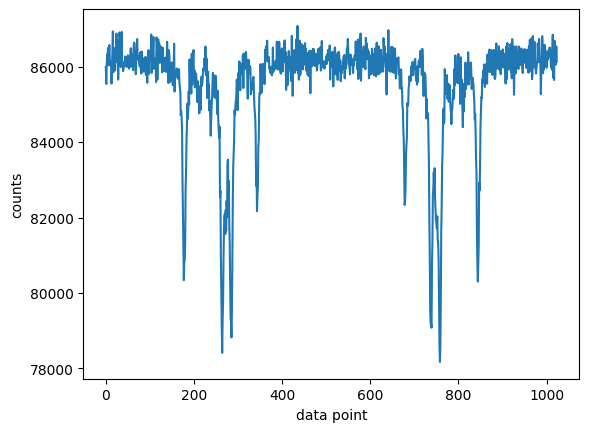

number of data points: 1024


In [3]:
plt.plot(data)
plt.xlabel("data point")
plt.ylabel("counts")
plt.show()

print('number of data points: {}'.format(len(data)))

## data folding

In [4]:
# use same settings as for velocity calibration

processed_data, lag = nx.data.AutoFold(processed_data,
                                       flip = 'right',  # determies which part of the spectrum is fliped
                                       factor = 100,   # interpolation on a 100 times finer grid
                                       method = "cubic") # or cubic, PChip, Akima

print('lag: {}'.format(lag))

lag: -1.13


## normalization

In [5]:
processed_data, norm_factor = nx.data.Normalize(data = processed_data,
                                                method = "baseline",   # 'max', 'min', 'value'
                                                # value = 0,            # only used when method is value
                                                # left_point=20,
                                                # right_point=250,
                                                # poly_order = 1        # use 1 in case you want to correct a tilted baseline
                                                )

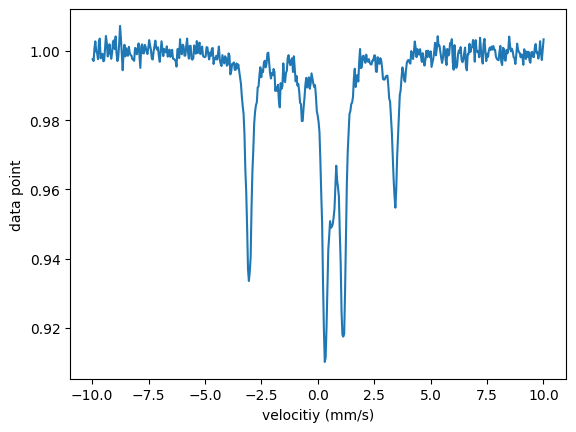

In [6]:
plt.plot(velocities, processed_data)
plt.xlabel("velocitiy (mm/s)")
plt.ylabel("data point")
plt.show()

## setup experiment

### hyperfine sites

In [7]:
# we assume to have two sites and an isotropic distribution (e.g. powder sample)

site1 = nx.Hyperfine(id = "site 1",
                     weight = nx.Var(1, min = 0, max = 1, fit = True, id = "weight 1"),
                     isomer = nx.Var(0, min = -1, max = 0, fit = True, id = "isomer 1"),
                     magnetic_field = nx.Var(15, min = 10, max = 25, fit = True, id = "magnetic field 1"),
                     quadrupole = nx.Var(0, min = -2, max = 2, fit = True, id = "quadrupole 1"),
                     # texture = 1,     # only used if isotropic = False
                     # broadening = 1   # model free broadening parameter
                     isotropic = True)

site2 = nx.Hyperfine(id = "site 2",
                     weight = nx.Var(1, min = 0, max = 1, fit = True, id = "weight 2"),
                     isomer = nx.Var(0, min = -1, max = 1, fit = True, id = "isomer 2"),
                     magnetic_field = 0,
                     quadrupole = nx.Var(0, min = -1, max = 1, fit = True, id = "quadrupole 2"),
                     isotropic = True)

### sample and experiment

#### always fit the sample thickness for a Moessabuer experiment
#### it serves as the scaling factor for the absorption

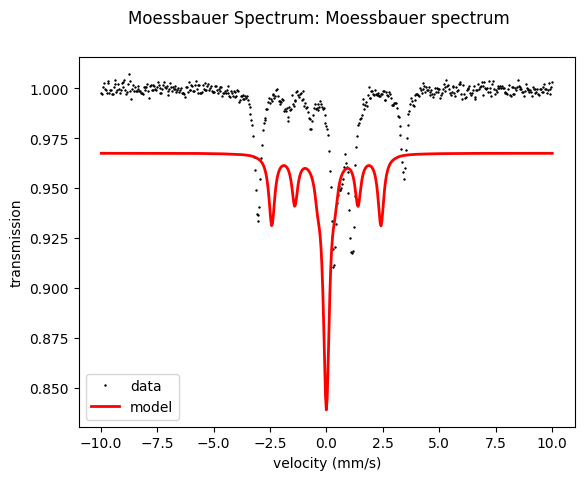

In [8]:
# always fit the sample thickness, it serves as the scaling factor for the absorption

sample = nx.SimpleSample(id = "sample",
                         thickness = nx.Var(3000, min=2000, max=4000, fit=True, id="t"),
                         composition = [["Fe", 1]],
                         density = 7.874,
                         isotope = nx.lib.moessbauer.Fe57,
                         abundance = 0.02119,
                         lamb_moessbauer = 0.796,
                         hyperfine_sites = [site1, site2]
                        )

beam = nx.Beam(id = "upolarized beam",
               polarization = 0,
               # mixing_angle = 0,   # ony for polarized beams
               # canting_angle = 0   # only for polarized beams
               # profile = "g"       # only for grazing incidence
               # fwhm = 0            # only for grazing incidence
               )

#beam.Unpolarized()   # not needed as polarization has been set to zero

exp = nx.Experiment(id = "experiment",
                    beam = beam,
                    objects = [sample],
                    isotope = nx.lib.moessbauer.Fe57)

spectrum = nx.MoessbauerSpectrum(id= "Moessbauer spectrum",
                                 experiment = exp,
                                 velocity = velocities,
                                 intensity_data = processed_data,
                                 # scaling = "auto"       # use a Var in csae you want to specify this value
                                 # background = "auto"    # use a Var in csae you want to specify this value
                                 # residual = nx.lib.residual.Sqrt()   # in case you want to change to Gaussian statistics use nx.lib.residual.StdDev()
                                 # kernel_type = "Lorentz"   # is standard for Moessbauer spectrum
                                 resolution = 2.197)  # value from calibration file or fit value as Var object

intensity = spectrum.Calculate()

spectrum.Plot(velocity = True
              # name=None    # provide a filename string to save under this filename
              # data=True,
              # residuals=True,
              # datacolor='black'
              # ... many more style options, see API
              # legend=True,
              # errors=False,
              # errorcap=2
              )

## setup fit

In [9]:
# create a fit object with a list of measurements to be fit in parallel.
fit = nx.Fit(id = "fit sample",
             measurements = [spectrum],
             # external_fit_variables = []    # for advanced fitting
             # einequalities = None           # for advanced fitting
            )

fit.options.method = "PagmoDiffEvol"   # or ""LevMar", "Annealing", "NaturalEvol", ...
# many fit.options area vailable, see API

# run the fit
fit.Evaluate()

# the fit creates an output file "fit_id_fit sample.txt" with the results


Run Fit instance with id: fit sample 

Starting fit with 1 measurement data set(s) and 10 fit parameter(s):

  no. |                           id |       initial value |              min |              max
    0 |                   ES scaling |             1.00718 |            1e-16 |          100.718
    1 |                    ES backgr |            0.099213 |                0 |           9.9213
    2 |                            t |                3000 |             2000 |             4000
    3 |                     weight 1 |                 0.5 |                0 |                1
    4 |                     isomer 1 |                   0 |               -1 |                0
    5 |             magnetic field 1 |                  15 |               10 |               25
    6 |                 quadrupole 1 |                   0 |               -2 |                2
    7 |                     weight 2 |                 0.5 |                0 |                1
    8 |          

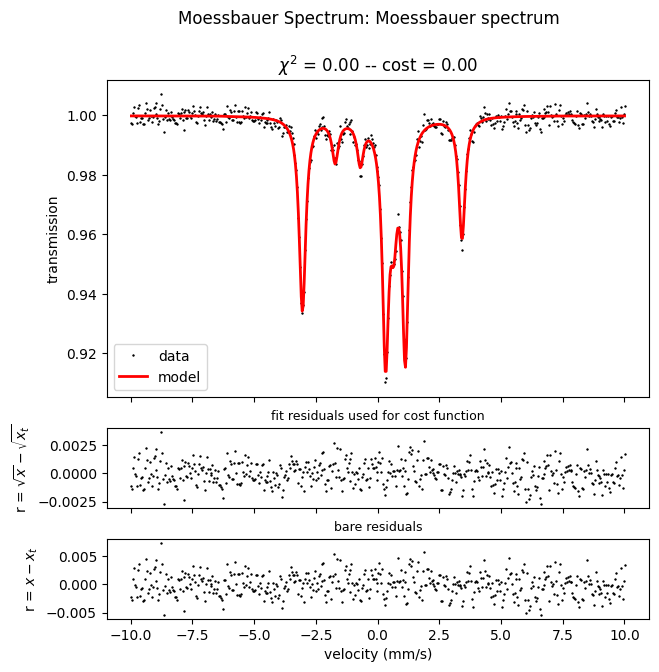

In [10]:
spectrum.Plot(velocity=True)

# in case the fit does not look good:
# restart when a global mehtod has been used (as here), maybe change parameter boundaries
# when a local method has been used, change start parameter (maybe also parameter boundaries)

### plot individual contributions

(1, 2, 512)


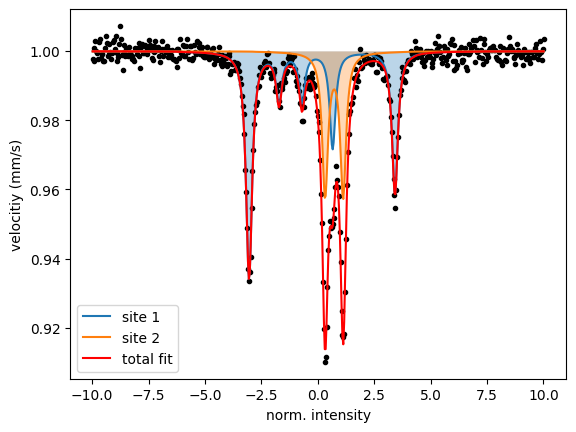

In [11]:
plt.plot(velocities, processed_data, '.', color='black')

#get intensities from individual components
intensity_sites = nx.tools.GetSiteSpectra(spectrum, sample)

# intensity_sites is a 3D array with first dimension being the layer, the second the site of the layer, and the 3rd the intensity
print(np.array(intensity_sites).shape)   # 1 layer, 2 sites, 512 data points

# go through intensity and layers of the sample in parallel to get intensity and id of the site
for intens_lay, lay in zip(intensity_sites, sample.layers):
    for intens_site, site in zip(intens_lay, lay.material.hyperfine_sites):
        plt.plot(velocities, intens_site, label = site.id)
        plt.fill_between(velocities, intens_site, intens_site[0], alpha = 0.3)

plt.plot(velocities, spectrum.result, color='red', label = "total fit")
plt.xlabel("norm. intensity")
plt.ylabel("velocitiy (mm/s)")
plt.legend()
plt.show()

### area ratios of intensities

In [12]:
area_sites = nx.tools.AreaSites(spectrum,
                                sample = sample,
                                norm = True)

print(np.array(area_sites).shape)   # 1 layer, 2 sites

print("")
print("Relative areas of the sites")
print(area_sites)

(1, 2)

Relative areas of the sites
[[0.6662509 0.3337491]]
